Clean model maker


In [1]:
#imports
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
import tensorflow.keras.metrics # import Precision, Recall,Accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from sklearn.metrics import classification_report

In [2]:
# path_to_dataset = os.path.join("..", "data")
# path_to_mini_dataset= os.path.join("..", "test_data", "0_test_miniset")#, "0_test_miniset")
#testing_mode=True

# Set parameters

In [43]:
#for data splits
batch_size = 16 #None = 1 #16 #32
img_height = 224
img_width = 224
seed_train_validation = 69 # Must be same for train_ds and val_ds
shuffle_value = True
#validation_split = 0.2 irrelevant




In [44]:
#Create train/val -- test is subset of val
# path_to_dataset = os.path.join("..", "test_data", "1_test_split_set")

# path_to_dataset_train = os.path.join(path_to_dataset, "train")
# path_to_dataset_test = os.path.join(path_to_dataset,  "test")
# path_to_dataset_val = os.path.join(path_to_dataset,   "validation")

In [58]:
new_way = True
label_mode = "int" 

def load_data_new_way():
    path_to_dataset = os.path.join("..", "test_data", "3_test_from_bucket2")
    path_to_dataset_train = os.path.join(path_to_dataset, "train")
    path_to_dataset_test = os.path.join(path_to_dataset,  "test")
    path_to_dataset_val = os.path.join(path_to_dataset,   "validation")
    
    X_train = image_dataset_from_directory(
        path_to_dataset_train,
        label_mode=label_mode,
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=shuffle_value
        )

    X_val = image_dataset_from_directory(
        path_to_dataset_val,
        label_mode=label_mode,
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=shuffle_value
        )

    X_test = image_dataset_from_directory(
        path_to_dataset_test,
        label_mode=label_mode,
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=False
        )
    return X_train,X_val,X_test
X_train, X_val, X_test = load_data_new_way()

#print sample label

Found 8001 files belonging to 8 classes.
Found 1600 files belonging to 8 classes.
Found 1600 files belonging to 8 classes.


In [59]:
path_to_dataset = os.path.join("..", "data")#, "2_test_from_bucket")
#new_way = False
def load_data_old_way():
    path_to_dataset = os.path.join("..", "data")#, "2_test_from_bucket")
    val_split = 0.3
    
    X_train = image_dataset_from_directory(
        path_to_dataset,
        validation_split=val_split,
        subset="training",
        label_mode="int",
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=shuffle_value
        )

    X_val_ds = image_dataset_from_directory(
        path_to_dataset,
        validation_split=val_split,
        subset="validation",
        label_mode="int",
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=shuffle_value
        )

    val_batches = tf.data.experimental.cardinality(X_val_ds)
    #print(val_batches//2)    # tf.Tensor(2131, shape=(), dtype=int64)

    X_val  = X_val_ds.take( val_batches // 2 ) #15%a
    X_test = X_val_ds.skip( val_batches // 2 ) #15%b
    
    return X_train,X_val,X_test

if new_way == False:
    X_train, X_val, X_test = load_data_old_way()

In [60]:
#(images, labels) = X_test
X_test


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [61]:
train_batches = tf.data.experimental.cardinality(X_train)
test_batches = tf.data.experimental.cardinality(X_test)
val_batches = tf.data.experimental.cardinality(X_val)

train_batches.numpy() , test_batches.numpy() ,val_batches.numpy()

(501, 100, 100)

In [62]:
X_val


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Prep model

test label: [7 1 6 0 4 5 3 5 0 7 4 4 2 1 1 7]
first test label: 7


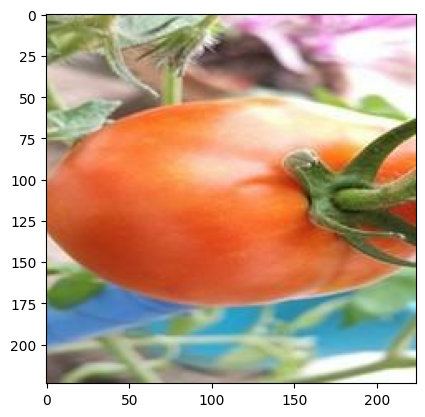

In [63]:
#get one image - I wish I knew a better way
count = 0
test_image, test_label = None, None

for image, label in X_train:#.take(1):
    if count == 0 :
        test_image = image.numpy()
        test_label = label.numpy()
    count+=1
    if count > 0: break
    
#if you want to see an image
print("test label:", test_label)
print("first test label:", test_label[0])
plt.imshow(test_image[0]/255)


In [64]:
in_shape = test_image[0].shape
in_shape

num_classes = len(X_train.class_names)
print("num_classes: ", num_classes)
print("in_shape: "   , in_shape)

num_classes:  8
in_shape:  (224, 224, 3)


# Create model

In [65]:
#for model
epochs = 100
patience = 20
dropout_rate = 0.2

#learning rate!

In [66]:
#declare model
def instantiate_model():
    model = models.Sequential()

    #normalise the inputs
    model.add(layers.Rescaling(1./255))

    #first convolutional layer - big kernels, few filters
    model.add(layers.Conv2D(16, kernel_size=(5,5), padding="same", activation="relu", input_shape=in_shape))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #second conv layer
    model.add(layers.Conv2D(32, kernel_size=(4,4), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

#     model.add(layers.Conv2D(32, kernel_size=(4,4), padding="same", activation="relu"))
#     model.add(layers.MaxPool2D(pool_size=(2,2)))
    
#     model.add(layers.Conv2D(32, kernel_size=(4,4), padding="same", activation="relu"))
#     model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    #third conv layer
    model.add(layers.Conv2D(64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Flatten
    model.add(layers.Flatten())

    #Dense layers - do we regularise the kernels?!
    model.add(layers.Dense(64, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    model.add(layers.Dropout(0.2) )
    #model.add(layers.Dense(64, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    #model.add(layers.Dropout(0.4) )
    #model.add(layers.Dense(64, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    #model.add(layers.Dropout(0.3) )
    model.add(layers.Dense(32, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    model.add(layers.Dropout(0.2) )
    model.add(layers.Dense(16, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    model.add(layers.Dropout(0.2) ) 

    #Last layer, convert for appropriate model output
    model.add(layers.Dense(num_classes, activation="softmax"))
    #model.add(layers.Dense(num_classes, activation="softmax"))

    
    return model

model = instantiate_model()

In [67]:
#compile model
from tensorflow.keras import metrics as mets
def compile_model(model):
    loss = "sparse_categorical_crossentropy"
    # loss = "categorical_crossentropy"
    optimizer = "adam"
    
    metrics = ["accuracy"]
    #metrics = [Precision(), Recall(), Accuracy()]
    #metrics = [Precision()]
    
    #metrics = [mets.SparseCategoricalAccuracy(), "accuracy"] #??
    # metrics = [mets.CategoricalAccuracy()]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
model = compile_model(model)


In [68]:
def fit_model(model):
    #prep for early stopping
    es = EarlyStopping(patience=patience, restore_best_weights=True)

    #fit
    history = model.fit(
            X_train, 
            validation_data=X_val, 
            #epochs=epochs,
            epochs=5,
            callbacks=[es], 
            verbose=1
        )
    return history, model

history, model = fit_model(model)


#if below error, RESTART KERNEL(s)!:
# 2023-03-08 16:05:03.024852: E tensorflow/stream_executor/cuda/cuda_dnn.cc:373] 
# Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR

Epoch 1/10
501/501 [==============================] - 12s 23ms/step - loss: 1.5893 - accuracy: 0.3683 - val_loss: 1.1569 - val_accuracy: 0.6144
Epoch 2/10
501/501 [==============================] - 11s 22ms/step - loss: 1.1229 - accuracy: 0.5809 - val_loss: 0.8309 - val_accuracy: 0.7331
Epoch 3/10
501/501 [==============================] - 11s 22ms/step - loss: 0.8897 - accuracy: 0.6818 - val_loss: 0.5472 - val_accuracy: 0.8250
Epoch 4/10
501/501 [==============================] - 11s 22ms/step - loss: 0.6834 - accuracy: 0.7679 - val_loss: 0.4433 - val_accuracy: 0.8794
Epoch 5/10
501/501 [==============================] - 11s 22ms/step - loss: 0.5509 - accuracy: 0.8206 - val_loss: 0.4619 - val_accuracy: 0.8700
Epoch 6/10
501/501 [==============================] - 11s 22ms/step - loss: 0.4308 - accuracy: 0.8575 - val_loss: 0.4006 - val_accuracy: 0.8919
Epoch 7/10
501/501 [==============================] - 11s 22ms/step - loss: 0.3396 - accuracy: 0.8969 - val_loss: 0.3716 - val_accuracy:

## Saving model

In [16]:
#model_name = "100_epochs_on_21_classes"
model_name = None
model_name = "sparse_accuracy_first_0907"

In [17]:
def save_model(model, model_name):
    path_to_models = os.path.join("..","models")
    
    if not model_name:
        print("please give the model a name! #goodpractice")
        print("model NOT saved")
        return None
    
    model_path = os.path.join(path_to_models, model_name)
    model.save(model_path)
    
    return f"model saved in {path_to_models} as {model_name}"

In [18]:
save_model(model, model_name)

INFO:tensorflow:Assets written to: ../models/sparse_accuracy_first_0907/assets


'model saved in ../models as sparse_accuracy_first_0907'

## Getting y out

In [69]:
#pull target out of tensorflow.dataset
#can do train test or val (seems that test is batches of 1?)
def get_y_from_X(X, batched=True):
    
    y_batched = []
    y = []
    
    for batch_image, batch_label in X:
        
        if batched:
            y_batched.append(batch_label.numpy())
        else:
            for image,label in zip(batch_image, batch_label):
                y.append(label.numpy())
     
    if batched:
        print("len y_batched", len(y_batched) )
        return y_batched
    else:
        print("len y", len(y))
        return y

In [70]:
count=0

for thing, label in X_test.take(1):
    if count == 0:
        print(label)
    count += 1


tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [71]:
def get_y_test(X_test_in):
    y_test = get_y_from_X(X_test_in, batched=False)
    return y_test
    
def get_y_pred(X_test_in):
    #gets array with probabilities
    # if model_name != None:
    #     print(f"getting predictions from {model_name}")
    # else:
    #     print(f"getting predictions from unnamed (probably not saved) 'model'")
        
    y_pred_0 = model.predict(X_test, verbose=1)
    y_pred = []
    
    for pred in y_pred_0:
        y_pred.append(pred.argmax())
        
    return y_pred


In [72]:
#get y_pred and y_true out of X_test, thanks to above funcs
y_pred = get_y_pred(X_test)
y_test = get_y_test(X_test)
y_pred;

100/100 [==============================] - 1s 10ms/step
len y 1600


In [73]:
path_to_dataset = os.path.join("..", "test_data", "3_test_from_bucket2")
if new_way:
    path_to_dataset_train = os.path.join(path_to_dataset, "train")
    path_to_dataset_test = os.path.join(path_to_dataset,  "test")
    path_to_dataset_val = os.path.join(path_to_dataset,   "validation")

In [74]:
def get_target_dict():
    if new_way:
        classes = os.listdir(path_to_dataset_train)
    else:
        classes = os.listdir(path_to_dataset)
    classes.sort()
    
    target_dict_out = {}
    for index, veg in enumerate(classes):
        target_dict_out[index] = veg
    
    return target_dict_out
target_dict = get_target_dict()
target_dict

{0: 'broccoli',
 1: 'cabbage',
 2: 'carrot',
 3: 'cauliflower',
 4: 'cucumber',
 5: 'potato',
 6: 'pumpkin',
 7: 'tomato'}

In [75]:
#can be useful to have them just as list
if new_way:
    classes_list = os.listdir(path_to_dataset_train)
else:
    classes_list = os.listdir(path_to_dataset)
classes_list.sort()
classes_list
classes_code = [i for i in range(len(classes_list))]
classes_code

[0, 1, 2, 3, 4, 5, 6, 7]

In [76]:
import pandas as pd
df = pd.DataFrame({"y_pred" : y_pred ,"y_test" : y_test})
df

,y_pred,y_test
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1595,7,7
1596,7,7
1597,7,7
1598,0,7


## Looking at results

In [77]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=classes_list))

              precision    recall  f1-score   support

    broccoli       0.86      0.87      0.86       200
     cabbage       0.76      0.89      0.82       200
      carrot       0.98      0.98      0.98       200
 cauliflower       0.90      0.85      0.88       200
    cucumber       0.91      0.98      0.94       200
      potato       1.00      0.99      0.99       200
     pumpkin       0.93      0.88      0.90       200
      tomato       0.96      0.81      0.88       200

    accuracy                           0.91      1600
   macro avg       0.91      0.91      0.91      1600
weighted avg       0.91      0.91      0.91      1600



<AxesSubplot:>

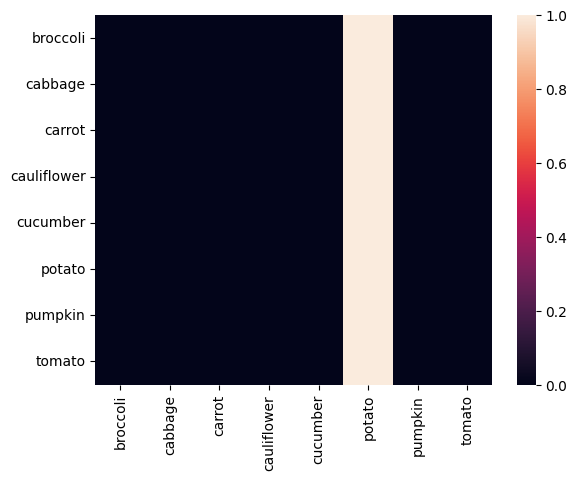

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test,y_pred, labels=classes_code , normalize='true') #true as in truth
sns.heatmap(cm,xticklabels=classes_list, yticklabels=classes_list)

# EXPERIMENTATION

will move the good stuff above

#idea 
create random prediction func that we can run and inspect incorrect predictions?

In [29]:
from sklearn.metrics import classification_report

In [30]:
out = classification_report(y_test, y_pred, output_dict=True)
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/
#https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/MultiLabelConfusionMatrix
#out

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
num_test = tf.data.experimental.cardinality(X_test)
num_test.numpy()

100

In [32]:
y_pred = model.predict(X_test, verbose=1)

100/100 [==============================] - 1s 9ms/step


In [33]:
num_test = tf.data.experimental.cardinality(X_test.take(1))
num_test.numpy()

1

In [34]:
out = classification_report(y_true, y_pred, output_dict=True)

NameError: name 'y_true' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
cm = confusion_matrix(y_test,y_pred, labels=classes_code , normalize='true')

# cm_df = pd.DataFrame(cm,
#                      index = target_dict.values(), 
#                      columns = target_dict.values())

sns.heatmap(cm,xticklabels=classes_list, yticklabels=classes_list)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/
#https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/MultiLabelConfusionMatrix

In [ ]:
print(classification_report(y_true, y_pred, target_names=classes_list))

In [ ]:
classes_list

In [ ]:
out

In [ ]:
#out

pred_comparison_limit = 10
count=0
for y_t, y_p in zip(y_true , y_pred):
    print(f"true: {y_t}  pred:{y_p}")
    count+=1
    
    if count > pred_comparison_limit:
        break

In [ ]:
#get labels from folders, must be done in 2 lines...
classes = os.listdir(path_to_dataset_train)
classes.sort()

In [ ]:
target_dict = {}
for index,classs in enumerate(classes):
    target_dict[index] = classs
    
print(target_dict.values())

In [ ]:
path_to_dataset

In [ ]:
#get one image - I wish I knew a better way
count = 0
test_image, test_label = None, None
for image, label in X_test.take(1):
    if count == 0 :
        test_image = image.numpy()
        test_label = label.numpy()
    count+=1
    if count > 0: break
#if you want to see an image
print(test_label[0])
plt.imshow(test_image[0]/255)

In [ ]:
model.evaluate(X_test, return_dict=True)